# **Actividad de la Semana 03**
**Maestría en Inteligencia Artificial Aplicada**  
**Curso:** Proyecto Integrador  
**Institución:** Instituto Tecnológico de Monterrey  
**Profesor titular:** Dra. Grettel Barceló Alonso  
**Profesor titular:** Dr. Luis Eduardo Falcón Morales  
**Profesora asistente** Mtra. Verónica Sandra Guzmán de Valle  

---

**Avance** #1

**Actividad** Análisis Exploratorio de Datos  


---

**Nombre del estudiante:** María Figueroa Bejarano

**Matrícula:** *A01114853*

**Nombre del estudiante:** David Hernández Castellanos  

**Matrícula:** *A01795964*

**Nombre del estudiante:** Francisco Javier Ramírez Arias


> Agregar bloque entrecomillado


**Matrícula:** A01316379  

---

# **Introducción al proyecto**

El proyecto tiene como objetivo automatizar el reconocimiento morfológico de células sanguíneas a partir de imágenes microscópicas, una tarea que tradicionalmente es realizada de manera manual por patólogos clínicos. En concreto, se pretende desarrollar un sistema computacional capaz de poder recibir como entrada una imagen digital de una célula sanguínea individual y determinar automáticamente a que tipo de célula pertenece.
El sistema debe ser capaz de distinguir entre ochos tipos de células sanguíneas
normales basándose exclusivamente en características morfológicas visibles de la imagen.

# **Descripción del dataset**


El dataset contiene:

• 17,092 imágenes digitales de células individuales de sangre.

• Las imágenes fueron adquiridas con el analizador automático CellaVision DM96,
en formato JPG, con resolución aproximada 360 x 360 pixeles y en un espacio de color RGB.

• Todas las imágenes están etiquetadas manualmente por patólogos clínicos expertos.

• Los datos esta anonimizados, sin información que permita identificar a los
pacientes.

• Las muestras provienen de individuos sanos, sin infecciones, enfermedades
hematológicas u oncológicas, y sin tratamiento farmacológico al momento de la
extracción.

• Las imágenes están organizadas en ocho clases de células sanguíneas normales: a)Neutrófilos, b) Eosinófilo, c) Basófilos, d) Linfocitos, e) Monocitos, f)
Granulocitos, h) Eritroblastos, i) Plaquetas

El dataset es open source de "A dataset for microscopic peripheral blood cell images for development of automatic recognition systems,” Mendeley Data. https://data.mendeley.com/datasets/snkd93bnjr/1

## **Paqueterías**

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import numpy as np
from PIL import Image
import random

## **Carga de datos**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **1._ ¿Hay valores faltantes en el conjunto de datos?**





El conjunto de datos está compuesto por imágenes digitales de células sanguíneas organizadas en carpetas, donde cada carpeta representa una clase celular. Cada observación corresponde a una imagen RGB en formato JPG con resolución aproximada de 360×360 píxeles.

La variable independiente es la imagen, mientras que la variable dependiente es el tipo de célula sanguínea (variable categórica multiclase con ocho categorías).

Dado que el conjunto de datos está compuesto únicamente por imágenes y etiquetas implícitas en la estructura de carpetas, no existen valores numéricos tabulares clásicos. Por lo tanto, las estadísticas descriptivas se centran en la frecuencia de las clases.

No se identifican valores faltantes, ya que todas las imágenes se encuentran correctamente almacenadas dentro de una carpeta de clase y no se detectan archivos corruptos o sin etiqueta.

Se muestran las 8 clases del proyecto en el dataset el cual esta dividido en carpetas

In [3]:
dataset_path = "/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_dataset_normal_DIB"
classes = os.listdir(dataset_path)
classes = [d for d in os.listdir(dataset_path)
    if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith(".")]

print("Clases detectadas:", classes)

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/MNA/Proyecto Integrador/PBC_dataset_normal_DIB'

Se muestra la cantidad de imagenes (muestras) que se tienen clasificadas por clase

In [ ]:
image_count = {}

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        image_count[class_name] = len(os.listdir(class_path))

image_count

{'neutrophil': 3330,
 'eosinophil': 3117,
 'erythroblast': 1551,
 'ig': 2895,
 'platelet': 2348,
 'lymphocyte': 1214,
 'monocyte': 1420,
 'basophil': 1218}

A continuación se muestra el porcentaje que representa cada clase con el total de muestras

In [ ]:
df_classes = pd.DataFrame.from_dict(image_count, orient='index', columns=['num_images'])
df_classes['percentage'] = (df_classes['num_images'] / df_classes['num_images'].sum()) * 100

df_classes

num_images  percentage
neutrophil          3330   19.481659
eosinophil          3117   18.235535
erythroblast        1551    9.073890
ig                  2895   16.936758
platelet            2348   13.736617
lymphocyte          1214    7.102323
monocyte            1420    8.307494
basophil            1218    7.125724

Aqui se representa la distribución de imagenes por clase

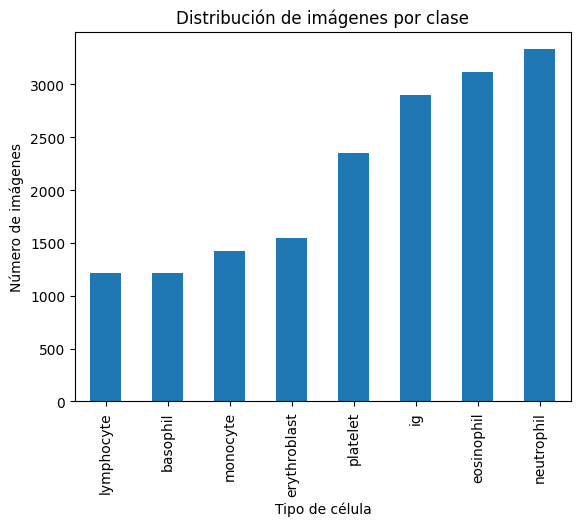

In [ ]:
df_classes['num_images'].sort_values().plot(kind='bar')
plt.title('Distribución de imágenes por clase')
plt.ylabel('Número de imágenes')
plt.xlabel('Tipo de célula')
plt.show()

Dado que el conjunto de datos está compuesto únicamente por imágenes y etiquetas asociadas, no se identifican valores faltantes en las variables principales (imagen y clase).

Todas las imágenes presentan dimensiones homogéneas y están correctamente asignadas a una clase específica, por lo que no es necesario aplicar técnicas de imputación ni manejo de ausencia de datos. Asimismo, no se detectan patrones de ausencia, ya que el dataset fue diseñado para ser utilizado directamente como datos crudos.

#### Vista general del dataset: ejemplos por clase

Para validar visualmente la coherencia del dataset, se muestran ejemplos aleatorios por clase. Esta inspección rápida permite confirmar que las imágenes corresponden a células individuales, que no existen archivos corruptos evidentes y que hay variabilidad intra-clase (diferencias naturales por tinción/iluminación y morfología), lo cual es esperable en imágenes médicas.

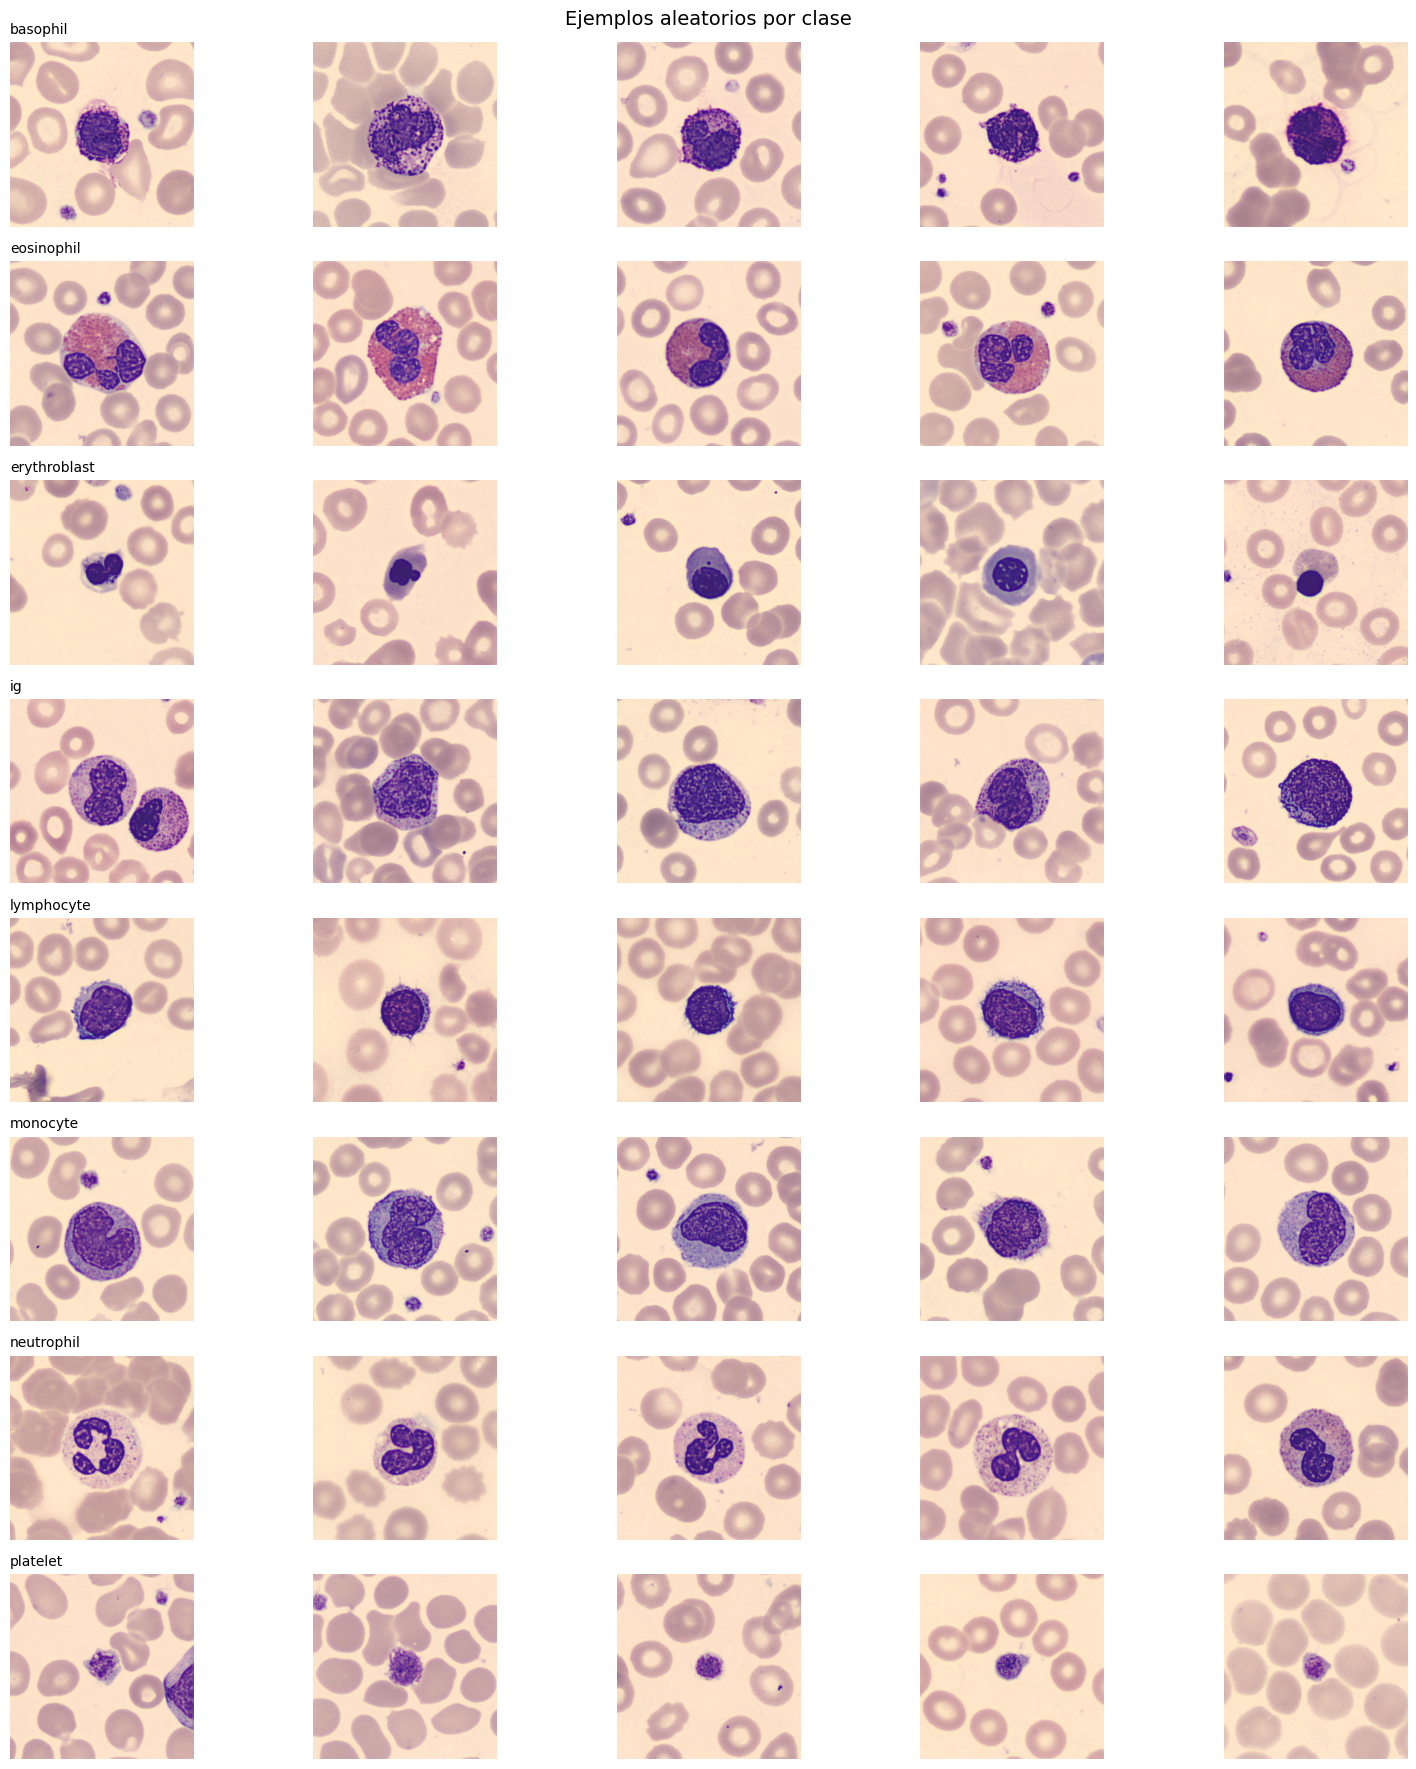

In [ ]:
# Reproducibilidad
RANDOM_SEED = 6
random.seed(RANDOM_SEED)

# Orden estable de clases
classes_sorted = sorted([c for c in classes if os.path.isdir(os.path.join(dataset_path, c))])

def plot_samples_per_class(dataset_path, classes, n_samples=5, figsize=(14, 10)):
    n_classes = len(classes)
    fig, axes = plt.subplots(n_classes, n_samples, figsize=figsize)

    if n_classes == 1:
        axes = [axes]
    if n_samples == 1:
        axes = [[ax] for ax in axes]

    for i, class_name in enumerate(classes):
        class_path = os.path.join(dataset_path, class_name)
        imgs = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        k = min(n_samples, len(imgs))
        sample_imgs = random.sample(imgs, k) if len(imgs) >= k else imgs

        sample_imgs = sample_imgs + [None] * (n_samples - len(sample_imgs))

        for j in range(n_samples):
            ax = axes[i][j] if n_classes > 1 else axes[0][j]
            ax.axis("off")
            if sample_imgs[j] is None:
                continue

            img_path = os.path.join(class_path, sample_imgs[j])
            try:
                img = Image.open(img_path).convert("RGB")
                ax.imshow(img)
            except Exception as e:
                ax.text(0.5, 0.5, "Error\nal cargar", ha="center", va="center")

            if j == 0:
                ax.set_title(class_name, fontsize=10, loc="left")

    plt.suptitle("Ejemplos aleatorios por clase", fontsize=14)
    plt.tight_layout()
    plt.show()

plot_samples_per_class(dataset_path, classes_sorted, n_samples=5, figsize=(16, 18))

# **2._ ¿Cuáles son las estadísticas resumidas del conjunto de datos?**


Dado que el conjunto de datos está basado en imágenes y no contiene variables numéricas tabulares, las estadísticas resumidas se centran en la estructura del dataset y en la distribución de las clases.


In [ ]:
total_images = sum(image_count.values())
num_classes = len(image_count)

print(f"Número total de imágenes: {total_images}")
print(f"Número de clases: {num_classes}")


Número total de imágenes: 17093
Número de clases: 8


La siguiente tabla muestra el número de imágenes y el porcentaje correspondiente a cada tipo celular.

In [ ]:
df_classes

num_images  percentage
neutrophil          3330   19.481659
eosinophil          3117   18.235535
erythroblast        1551    9.073890
ig                  2895   16.936758
platelet            2348   13.736617
lymphocyte          1214    7.102323
monocyte            1420    8.307494
basophil            1218    7.125724

Se observa que las clases no están perfectamente balanceadas, aunque ninguna presenta una subrepresentación extrema. Esta distribución es adecuada para tareas de clasificación multiclase, considerando técnicas de compensación durante el entrenamiento si es necesario.

La siguiente tabla muestra la distribución de tamaños reales de las imágenes del conjunto de datos.

La mayoría de las muestras presenta dimensiones muy similares de 363x360 pixeles, con diferencias de pocos píxeles respecto al tamaño nominal.

Estas variaciones no se consideran valores atípicos erróneos, sino una característica esperada del proceso automático de adquisición y recorte de imágenes del sistema CellaVision DM96. No se identificaron imágenes con dimensiones extremas, canales inconsistentes o archivos corruptos.

En consecuencia, no se eliminarán imágenes del conjunto de datos. Las variaciones detectadas serán gestionadas mediante un redimensionamiento uniforme durante la etapa de preprocesamiento, con el fin de garantizar la homogeneidad de entrada para los modelos de clasificación.

#### Distribución de dimensiones de las imágenes (shape) y consistencia del dataset

Aunque el dataset fue generado por un sistema automático, es importante validar la consistencia del tamaño de entrada. Variaciones pequeñas de alto/ancho pueden ser normales (recortes o exportación), pero para entrenamiento se recomienda estandarizar el tamaño (resize) para asegurar entradas homogéneas y mejorar estabilidad del modelo.

In [ ]:
def get_image_shapes(dataset_path, classes, max_images_per_class=None):
    """
    Extrae shapes (alto, ancho, canales) de las imágenes del dataset.
    max_images_per_class: si quieres acelerar, limita cuántas imágenes leer por clase.
    """
    shapes = []
    unreadable = 0

    for class_name in classes:
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue

        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        if max_images_per_class is not None:
            files = files[:max_images_per_class]

        for fname in files:
            fpath = os.path.join(class_path, fname)
            try:
                img = Image.open(fpath).convert("RGB")
                w, h = img.size
                shapes.append((h, w, 3))
            except Exception:
                unreadable += 1

    return shapes, unreadable


shapes_list, unreadable_count = get_image_shapes(dataset_path, classes_sorted, max_images_per_class=None)

shape_counts = Counter(shapes_list)

df_shapes = (
    pd.DataFrame(shape_counts.items(), columns=["dimension", "num_images"])
      .sort_values("num_images", ascending=False)
      .reset_index(drop=True)
)

df_shapes.head(10), unreadable_count

(       dimension  num_images
 0  (363, 360, 3)       16639
 1  (369, 366, 3)         250
 2  (360, 360, 3)         198
 3  (361, 360, 3)           2
 4  (360, 362, 3)           1
 5  (360, 359, 3)           1
 6  (360, 361, 3)           1,
 1)

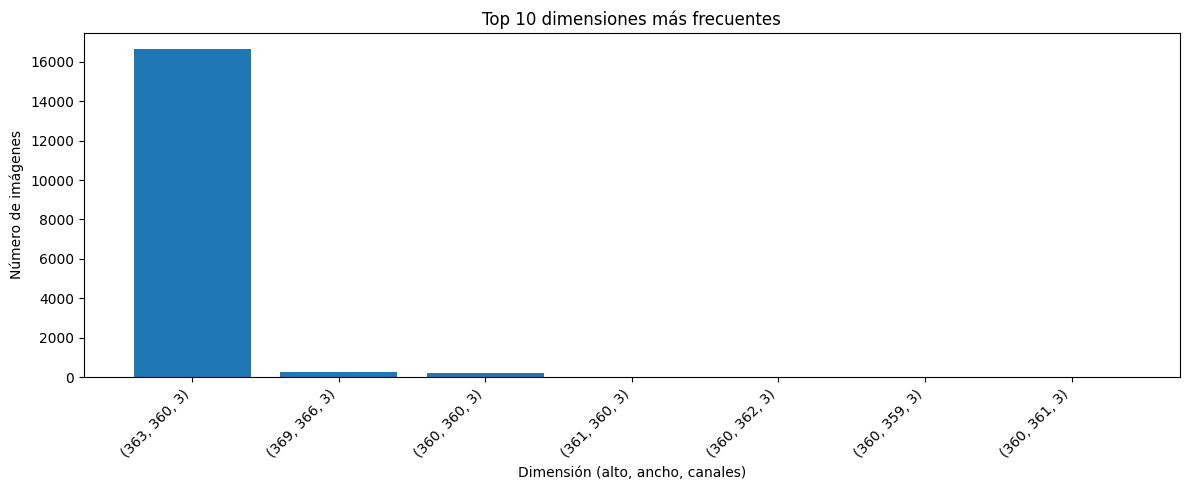

In [ ]:
# Visual: Top shapes por frecuencia
top_n = 10
df_top = df_shapes.head(top_n).copy()

plt.figure(figsize=(12, 5))
plt.bar(range(len(df_top)), df_top["num_images"])
plt.xticks(range(len(df_top)), df_top["dimension"].astype(str), rotation=45, ha="right")
plt.title(f"Top {top_n} dimensiones más frecuentes")
plt.ylabel("Número de imágenes")
plt.xlabel("Dimensión (alto, ancho, canales)")
plt.tight_layout()
plt.show()

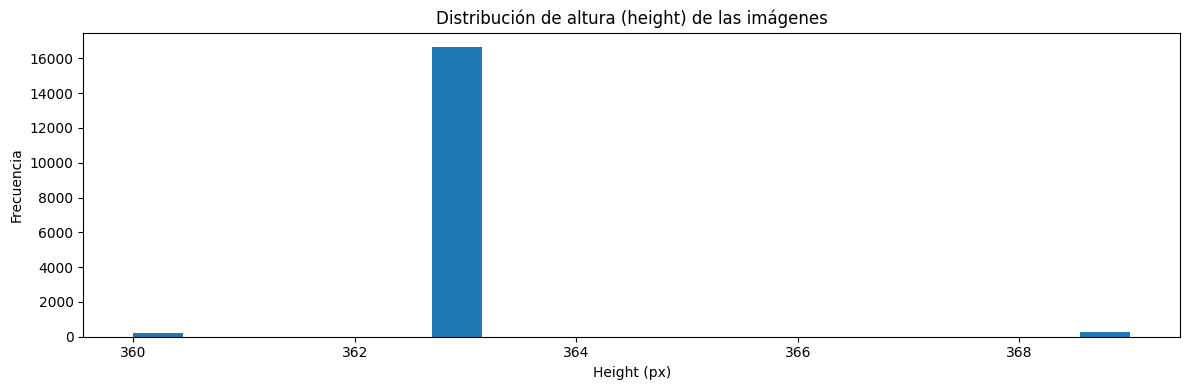

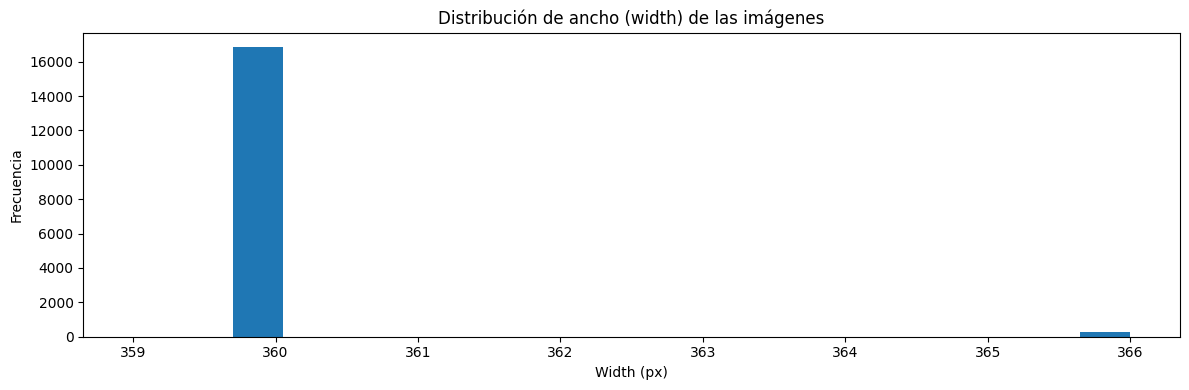

In [ ]:
heights = [d[0] for d in shapes_list]
widths  = [d[1] for d in shapes_list]

plt.figure(figsize=(12, 4))
plt.hist(heights, bins=20)
plt.title("Distribución de altura (height) de las imágenes")
plt.xlabel("Height (px)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 4))
plt.hist(widths, bins=20)
plt.title("Distribución de ancho (width) de las imágenes")
plt.xlabel("Width (px)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

Se observa que la gran mayoría de imágenes comparten dimensiones similares, con variaciones menores atribuibles a recortes o condiciones de exportación. Para garantizar una entrada homogénea y mejorar la generalización, se recomienda aplicar redimensionamiento (resize) a una resolución objetivo durante el preprocesamiento, evitando introducir sesgos por diferencias de escala.

In [ ]:
total_imgs = df_shapes["num_images"].sum()
dominant_shape = df_shapes.iloc[0]["dimension"]
dominant_count = df_shapes.iloc[0]["num_images"]
dominant_pct = dominant_count / total_imgs * 100

print(f"Total imágenes analizadas: {total_imgs}")
print(f"Dimensión más frecuente: {dominant_shape} con {dominant_count} imágenes ({dominant_pct:.2f}%)")

Total imágenes analizadas: 17092
Dimensión más frecuente: (363, 360, 3) con 16639 imágenes (97.35%)


Debido a que las imágenes corresponden a células individuales previamente segmentadas, cada muestra representa una observación completa e independiente, lo que permite que las estadísticas resumidas describan fielmente la estructura y distribución del conjunto de datos sin interferencias contextuales.

# **3._ ¿Hay valores atípicos en el conjunto de datos?**

En este apartado se evalúa la existencia de valores atípicos en el conjunto de datos a partir de características estadísticas extraídas de las imágenes, como la intensidad media y la variabilidad de los canales RGB. Este análisis se realiza con el objetivo de identificar posibles imágenes atípicas en el conjunto de datos, como aquellas con contrastes excesivamente altos, imágenes demasiado oscuras, saturadas o con distribuciones de color anómalas. La detección de este tipo de casos permite verificar la calidad de las imágenes y asegurar que las variaciones observadas correspondan a características naturales de las células y no a errores de adquisición o procesamiento.

In [ ]:
pixel_stats = []

for class_name in classes:
    class_path = os.path.join(dataset_path, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            img = Image.open(img_path).convert("RGB")
            img_array = np.array(img)

            pixel_stats.append({
                "class": class_name,
                "mean_R": img_array[:, :, 0].mean(),
                "mean_G": img_array[:, :, 1].mean(),
                "mean_B": img_array[:, :, 2].mean(),
                "std_R": img_array[:, :, 0].std(),
                "std_G": img_array[:, :, 1].std(),
                "std_B": img_array[:, :, 2].std()
            })
        except:
            continue

df_pixels = pd.DataFrame(pixel_stats)
df_pixels.head()


class      mean_R      mean_G      mean_B      std_R      std_G  \
0  neutrophil  225.414103  192.195845  182.773829  38.849654  48.107777   
1  neutrophil  224.388881  189.887504  183.909833  39.219186  46.813850   
2  neutrophil  217.509948  184.012496  180.024633  39.149552  44.995745   
3  neutrophil  230.521335  201.365741  188.139325  39.692153  44.548649   
4  neutrophil  229.826714  194.979362  185.124204  33.264616  39.732024   

       std_B  
0  19.351589  
1  19.283485  
2  19.771231  
3  17.991612  
4  17.726394

A partir de las primeras observaciones por imagen (ej. neutrophil), se observa que los valores de intensidad media (mean_R, mean_G, mean_B) y dispersión (std_R, std_G, std_B) se mantienen dentro de rangos coherentes entre imágenes de la misma clase. No se identifican valores extremos evidentes a simple inspección, lo cual sugiere una distribución relativamente homogénea de intensidades a nivel intra-clase

In [ ]:
df_pixels.describe()

mean_R        mean_G        mean_B         std_R         std_G  \
count  17092.000000  17092.000000  17092.000000  17092.000000  17092.000000   
mean     222.828707    190.906122    184.002184     38.967006     45.923675   
std        8.247556      8.808263      5.875798      7.320775      7.782016   
min      174.514073    138.319628    166.059014     10.797745     15.785583   
25%      217.997431    185.311184    180.861371     36.622297     42.940982   
50%      222.982660    190.656753    183.284787     39.932281     47.312078   
75%      228.048994    196.518314    186.121608     43.232999     50.697048   
max      252.353436    224.794322    223.489071     66.929872     75.410516   

              std_B  
count  17092.000000  
mean      19.382482  
std        2.626259  
min        5.300962  
25%       17.998647  
50%       19.662542  
75%       21.051932  
max       29.672857

Las estadísticas resumidas para las 17,092 imágenes muestran:

Medias estables de intensidad:

mean_R ≈ 222.8, mean_G ≈ 190.9, mean_B ≈ 184.0

Desviaciones estándar moderadas, sin dispersión extrema:

std_R ≈ 39, std_G ≈ 46, std_B ≈ 19

Los valores mínimos y máximos se encuentran alejados de cero y del límite superior de 255, indicando que no existen imágenes saturadas ni excesivamente oscuras.

In [ ]:
df_pixels.groupby("class")[["mean_R", "mean_G", "mean_B"]].mean()

mean_R      mean_G      mean_B
class                                           
basophil      220.048263  187.953521  183.649320
eosinophil    222.176817  188.656194  182.449413
erythroblast  228.290703  198.276726  187.398531
ig            217.281036  185.661159  183.218722
lymphocyte    223.124070  191.674115  183.917446
monocyte      215.912685  183.868039  182.411102
neutrophil    222.146791  189.908148  182.974929
platelet      233.365231  202.296944  187.431526

El promedio de intensidades por clase revela diferencias esperadas entre tipos celulares:

Clases como platelet y erythroblast presentan intensidades medias más altas.

Clases como monocyte e ig muestran valores ligeramente menores.

Estas variaciones no representan valores atípicos, sino características propias de cada clase, lo cual es deseable para tareas de clasificación.

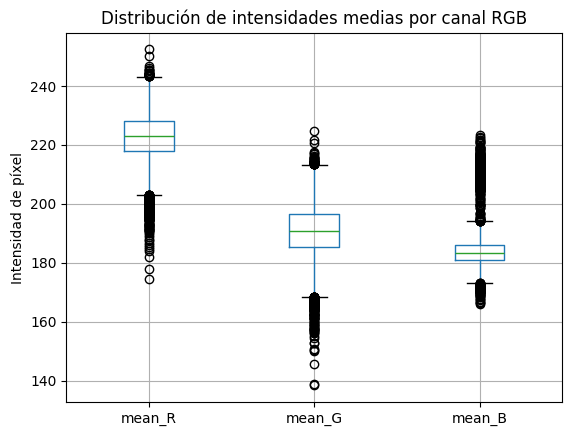

In [ ]:
df_pixels[["mean_R", "mean_G", "mean_B"]].boxplot()
plt.title("Distribución de intensidades medias por canal RGB")
plt.ylabel("Intensidad de píxel")
plt.show()

Se observa que los tres canales presentan distribuciones compactas, con medianas bien definidas y rangos intercuartílicos relativamente estrechos, lo que indica una variabilidad controlada en las intensidades de las imágenes.

Aunque se identifican puntos fuera de los bigotes del boxplot, estos corresponden a valores extremos estadísticos dentro del rango permitido por el espacio de color RGB y no representan imágenes completamente negras, blancas o con contrastes anómalos. La presencia de estos valores se asocia a variaciones naturales de iluminación, tinción y morfología celular entre muestras.

In [ ]:
Q1 = df_pixels[["mean_R", "mean_G", "mean_B"]].quantile(0.25)
Q3 = df_pixels[["mean_R", "mean_G", "mean_B"]].quantile(0.75)
IQR = Q3 - Q1

outliers = df_pixels[
    (df_pixels[["mean_R", "mean_G", "mean_B"]] < (Q1 - 1.5 * IQR)) |
    (df_pixels[["mean_R", "mean_G", "mean_B"]] > (Q3 + 1.5 * IQR))
]

outliers.dropna().shape


(0, 7)

Esto indica que ninguna imagen fue identificada como valor atípico en términos de intensidades medias de color.

No se identificaron valores atípicos en el conjunto de datos.

Tanto el análisis descriptivo como el análisis visual mediante boxplots y la detección formal basada en el rango intercuartílico (IQR) indican que las intensidades de los canales RGB se encuentran dentro de rangos esperados y consistentes. Las variaciones observadas corresponden a diferencias naturales entre tipos celulares y no a anomalías en los datos.

Esto sugiere que el conjunto de datos presenta una distribución homogénea y adecuada para su uso en etapas posteriores de preprocesamiento y entrenamiento de modelos de clasificación.

#### Distribución de intensidades RGB: evidencia para normalización/estandarización

Se analiza la distribución de intensidades de pixeles por canal (R, G, B) para identificar sesgos, rangos dominantes y posibles efectos de iluminación/tinción. Este análisis apoya decisiones de preprocesamiento como normalización [0,1] o estandarización por canal.

In [ ]:
def sample_image_paths(dataset_path, classes, n_images_total=400):
    all_paths = []
    for c in classes:
        class_path = os.path.join(dataset_path, c)
        if not os.path.isdir(class_path):
            continue
        files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        all_paths.extend([os.path.join(class_path, f) for f in files])

    n = min(n_images_total, len(all_paths))
    return random.sample(all_paths, n)

def compute_pixel_histograms(image_paths, resize_to=None, bins=256):
    hist_R = np.zeros(bins, dtype=np.int64)
    hist_G = np.zeros(bins, dtype=np.int64)
    hist_B = np.zeros(bins, dtype=np.int64)
    read_errors = 0

    for p in image_paths:
        try:
            img = Image.open(p).convert("RGB")
            if resize_to is not None:
                img = img.resize(resize_to)
            arr = np.asarray(img)  # H,W,3 uint8

            r = arr[:,:,0].ravel()
            g = arr[:,:,1].ravel()
            b = arr[:,:,2].ravel()

            hist_R += np.bincount(r, minlength=bins)
            hist_G += np.bincount(g, minlength=bins)
            hist_B += np.bincount(b, minlength=bins)
        except Exception:
            read_errors += 1

    return hist_R, hist_G, hist_B, read_errors

sample_paths = sample_image_paths(dataset_path, classes_sorted, n_images_total=400)

hist_R, hist_G, hist_B, errs = compute_pixel_histograms(sample_paths, resize_to=(128,128), bins=256)
print("Errores de lectura:", errs)
print("Imágenes muestreadas:", len(sample_paths))

Errores de lectura: 0
Imágenes muestreadas: 400


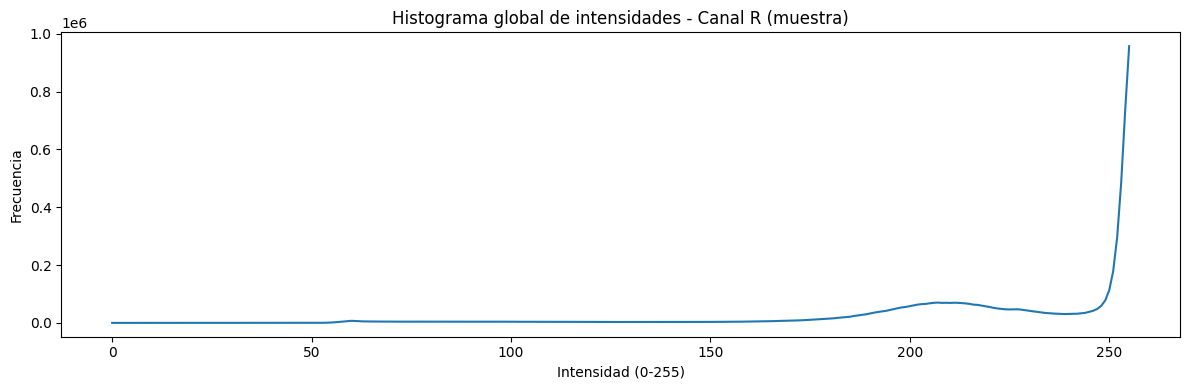

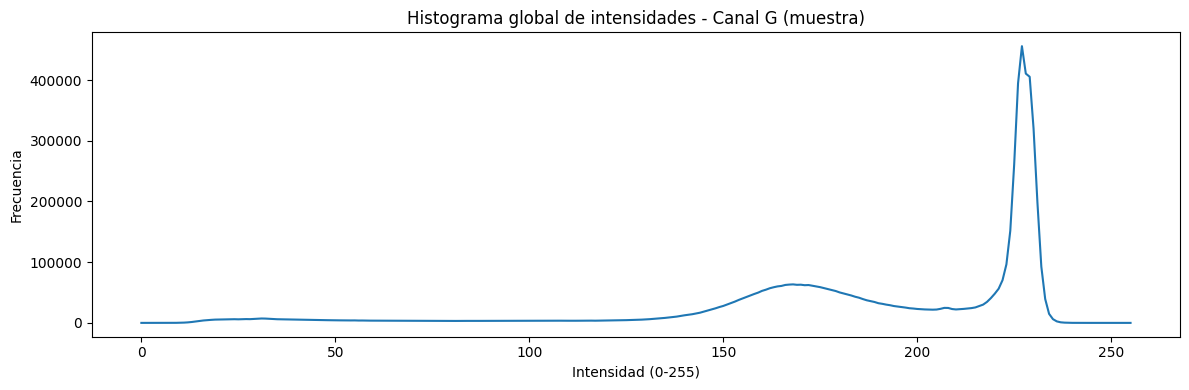

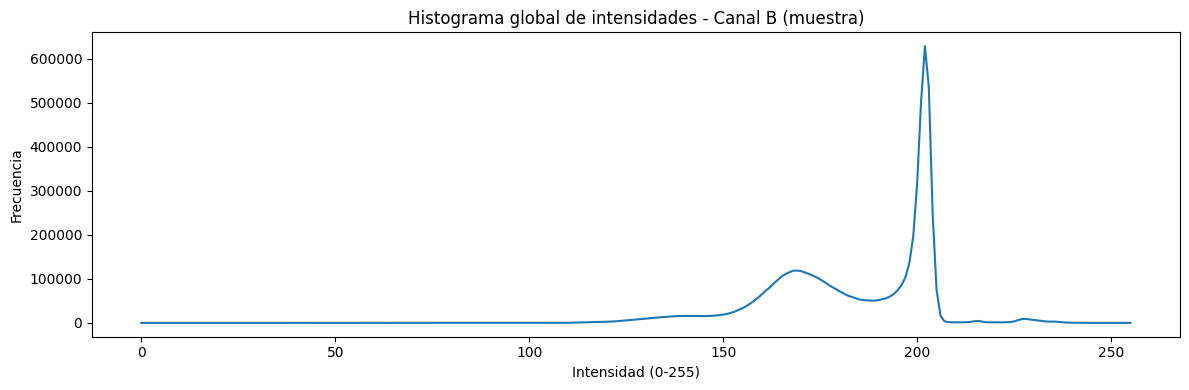

In [ ]:
x = np.arange(256)

plt.figure(figsize=(12,4))
plt.plot(x, hist_R)
plt.title("Histograma global de intensidades - Canal R (muestra)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(x, hist_G)
plt.title("Histograma global de intensidades - Canal G (muestra)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.plot(x, hist_B)
plt.title("Histograma global de intensidades - Canal B (muestra)")
plt.xlabel("Intensidad (0-255)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


basophil: n=80, errores=0


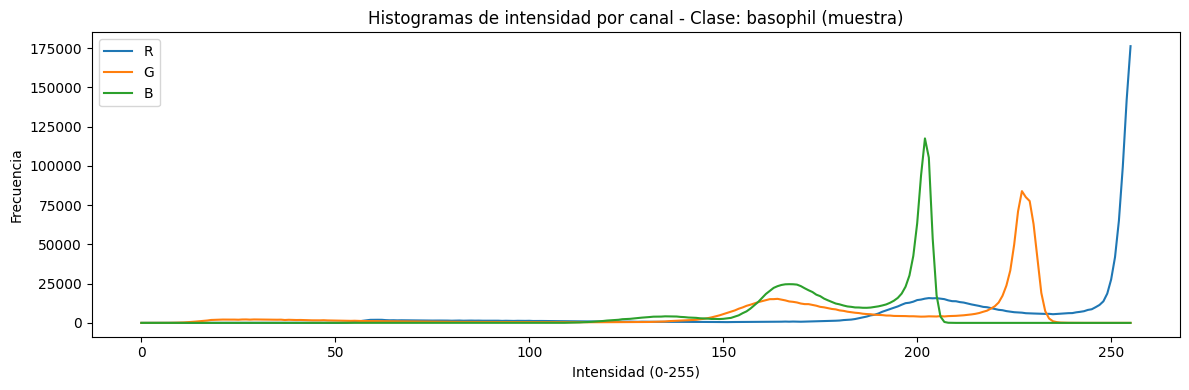

eosinophil: n=80, errores=0


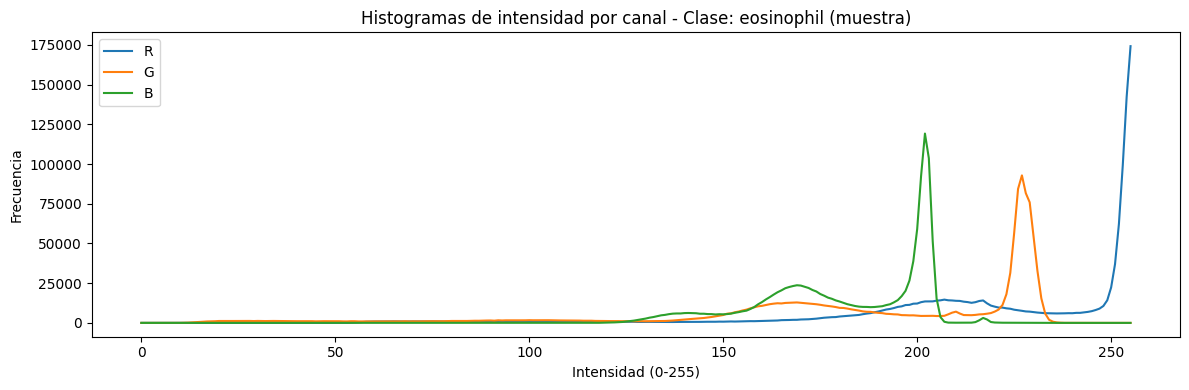

erythroblast: n=80, errores=0


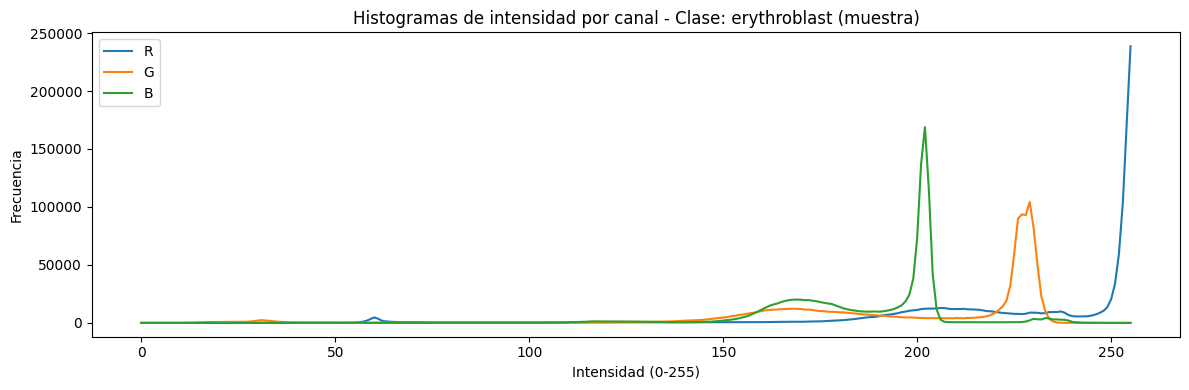

ig: n=80, errores=0


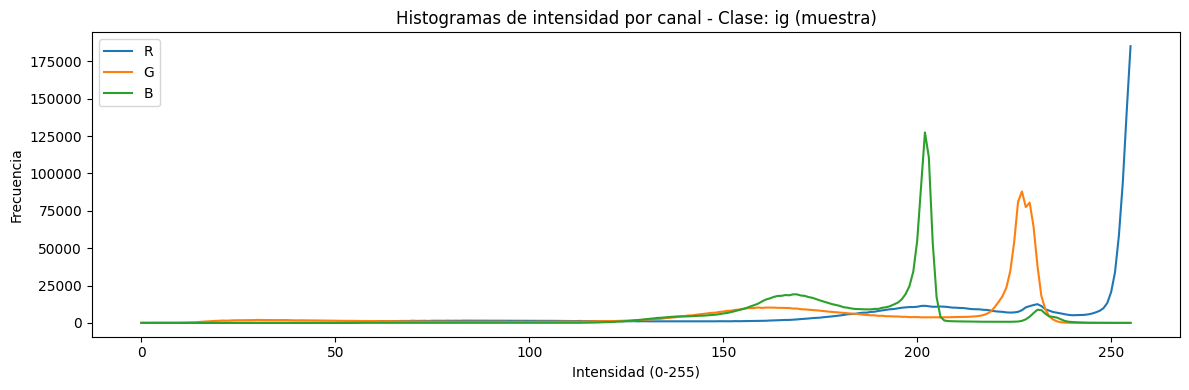

In [ ]:
def sample_paths_per_class(dataset_path, class_name, n=80):
    class_path = os.path.join(dataset_path, class_name)
    files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    n = min(n, len(files))
    return [os.path.join(class_path, f) for f in random.sample(files, n)]

def class_channel_hist(dataset_path, class_name, n_imgs=80, resize_to=(128,128)):
    paths = sample_paths_per_class(dataset_path, class_name, n=n_imgs)
    hR, hG, hB, errs = compute_pixel_histograms(paths, resize_to=resize_to, bins=256)
    return hR, hG, hB, errs, len(paths)

classes_to_plot = classes_sorted[:4]
x = np.arange(256)

for c in classes_to_plot:
    hR, hG, hB, errs, n_used = class_channel_hist(dataset_path, c, n_imgs=80, resize_to=(128,128))
    print(f"{c}: n={n_used}, errores={errs}")

    plt.figure(figsize=(12,4))
    plt.plot(x, hR, label="R")
    plt.plot(x, hG, label="G")
    plt.plot(x, hB, label="B")
    plt.title(f"Histogramas de intensidad por canal - Clase: {c} (muestra)")
    plt.xlabel("Intensidad (0-255)")
    plt.ylabel("Frecuencia")
    plt.legend()
    plt.tight_layout()
    plt.show()

Los histogramas globales muestran cómo se distribuyen las intensidades en cada canal, permitiendo evaluar si existen sesgos hacia rangos altos/bajos y si hay indicios de saturación (acumulación extrema en 0 o 255). En las comparaciones por clase se observan diferencias esperables asociadas a la tinción y morfología, con solapamiento parcial entre categorías. En consecuencia, resulta recomendable normalizar las imágenes (por ejemplo, escalar a [0,1]) y, de ser necesario, estandarizar por canal para estabilizar el entrenamiento y mejorar la generalización.

Errores: 0
Saturación 0% - media: 5.086263020833332e-06 max: 0.002034505208333333
Saturación 255% - media: 4.8701019287109375 max: 13.539632161458334


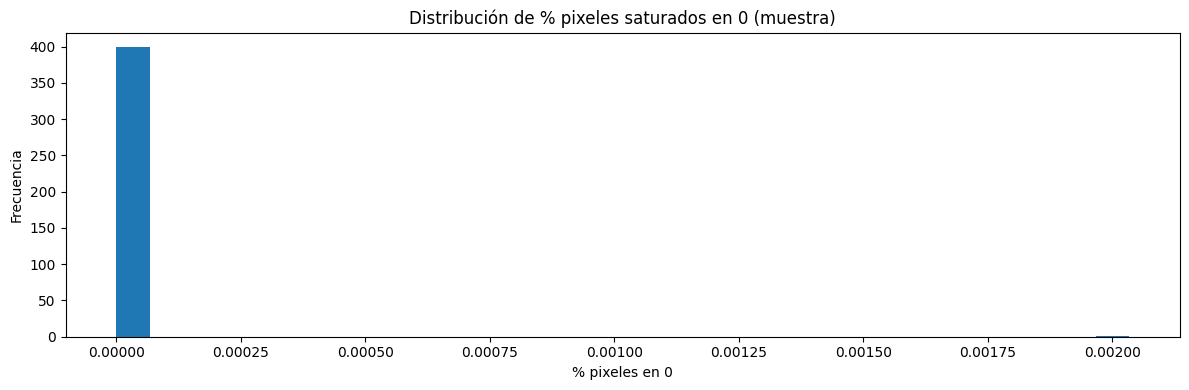

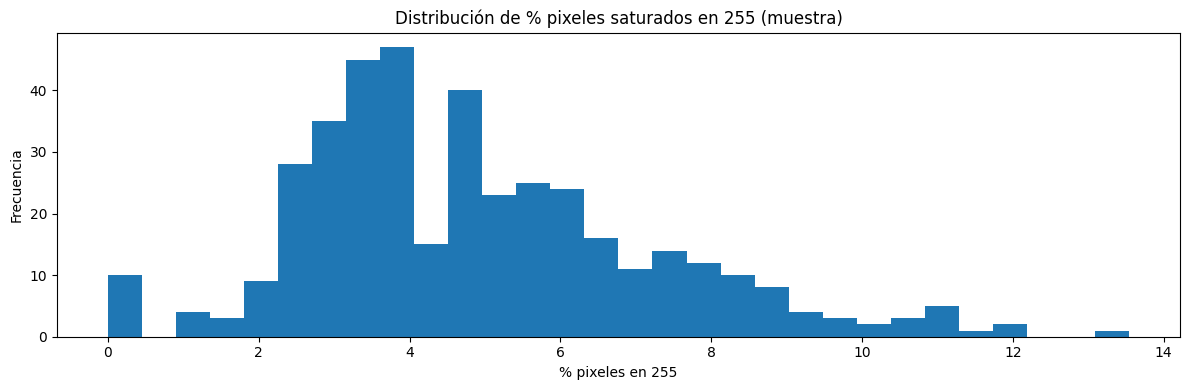

In [ ]:
def saturation_stats(image_paths, resize_to=(128,128), thr_low=0, thr_high=255):
    # porcentaje de pixeles en 0 o 255 (o umbrales) por imagen
    sat0 = []
    sat255 = []
    errors = 0

    for p in image_paths:
        try:
            img = Image.open(p).convert("RGB")
            if resize_to is not None:
                img = img.resize(resize_to)
            arr = np.asarray(img)
            total = arr.size

            sat0.append(np.mean(arr == thr_low) * 100)
            sat255.append(np.mean(arr == thr_high) * 100)
        except Exception:
            errors += 1

    return np.array(sat0), np.array(sat255), errors

sat0, sat255, e = saturation_stats(sample_paths, resize_to=(128,128))
print("Errores:", e)
print("Saturación 0% - media:", sat0.mean(), "max:", sat0.max())
print("Saturación 255% - media:", sat255.mean(), "max:", sat255.max())

plt.figure(figsize=(12,4))
plt.hist(sat0, bins=30)
plt.title("Distribución de % pixeles saturados en 0 (muestra)")
plt.xlabel("% pixeles en 0")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

plt.figure(figsize=(12,4))
plt.hist(sat255, bins=30)
plt.title("Distribución de % pixeles saturados en 255 (muestra)")
plt.xlabel("% pixeles en 255")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# **4._ ¿Cuál es la cardinalidad de las variables categoricas?**




En el conjunto de datos analizado, la única variable categórica corresponde a la clase de la célula sanguínea, la cual está definida por la carpeta de origen de cada imagen. No se dispone de variables categóricas adicionales como sexo, edad, paciente o tiempo de adquisición, ya que el dataset se encuentra anonimizado y contiene únicamente imágenes de células individuales.

Esto reduce la complejidad del modelo, evita problemas asociados a alta cardinalidad (como sobreajuste o representaciones dispersas) y facilita la interpretación de los resultados.

Además, al tratarse de imágenes de células individuales previamente segmentadas, cada observación pertenece de forma inequívoca a una única clase, eliminando ambigüedades en la asignación de etiquetas.

# **5._ ¿Existen distribuciones sesgadas en el conjunto de datos?**

El análisis de la distribución de las clases celulares revela que el conjunto de datos no está perfectamente balanceado. Aunque todas las clases cuentan con un número considerable de muestras, existen diferencias notables en su frecuencia:

Clases como neutrophil, eosinophil e immature granulocyte (IG) concentran una mayor proporción de imágenes.

Clases como basophil y lymphocyte presentan una menor representación relativa.

Este desbalance introduce un sesgo en la distribución de la variable objetivo, lo cual puede influir en el entrenamiento de modelos de clasificación, favoreciendo las clases mayoritarias si no se toman medidas adecuadas.

In [ ]:
df_classes

num_images  percentage
neutrophil          3330   19.481659
eosinophil          3117   18.235535
erythroblast        1551    9.073890
ig                  2895   16.936758
platelet            2348   13.736617
lymphocyte          1214    7.102323
monocyte            1420    8.307494
basophil            1218    7.125724

# **6._ ¿Necesitamos aplicar alguna transformación no lineal?**




A partir del análisis exploratorio realizado, no es necesario aplicar transformaciones no lineales a las variables extraídas del conjunto de datos. Las distribuciones de las intensidades medias de los canales RGB son aproximadamente simétricas, no presentan colas extremas ni valores atípicos relevantes, y se mantienen dentro de rangos físicamente plausibles.

Las ligeras asimetrías observadas responden a variaciones naturales de iluminación, tinción y morfología celular, propias del dominio de imágenes hematológicas, y no a problemas estructurales del conjunto de datos. En este contexto, transformaciones no lineales como logaritmos, Box-Cox o raíces cuadradas no aportarían beneficios significativos.

**Aqui van los comentarios en base a los resultados del análisis**

# **7._ Se identifican tendencias temporales (En caso de que el conjunto incluya una dimensión de tiempo)**

El conjunto de datos no incluye una dimensión temporal, por lo que no es posible ni necesario realizar análisis de tendencias temporales.

# **8._ ¿Hay correlación entre las variables dependientes e independietes?**

No se observa una correlación lineal directa entre variables independientes y la variable dependiente debido a la naturaleza categórica de la clase objetivo. No obstante, el análisis exploratorio evidencia que las características de intensidad de color presentan diferencias entre clases, lo que confirma su relevancia para la tarea de clasificación.

# **9._ ¿Cómo se distribuyen los datos en función de las diferentes categorías? (análisis bivariado)**

En este conjunto de datos, la variable dependiente corresponde a la clase de la célula sanguínea, mientras que las variables independientes analizadas durante el EDA son características numéricas derivadas de las imágenes, como las intensidades medias y la desviación estándar de los canales RGB.

Dado que la variable dependiente es categórica y las variables independientes son continuas, no es apropiado aplicar directamente medidas de correlación lineal clásicas como el coeficiente de Pearson. No obstante, se realizó un análisis exploratorio comparando las distribuciones de las características de color entre clases.

Para analizar la relación entre las variables independientes y la variable categórica objetivo, se realizó un análisis bivariado comparando las características estadísticas extraídas de las imágenes (intensidades medias y variabilidad de los canales RGB) en función de las distintas clases celulares.



El análisis de las intensidades medias por canal RGB muestra que cada tipo de célula presenta patrones de color característicos:


In [ ]:
df_pixels.groupby("class")[["mean_R", "mean_G", "mean_B"]].mean()

mean_R      mean_G      mean_B
class                                           
basophil      220.048263  187.953521  183.649320
eosinophil    222.176817  188.656194  182.449413
erythroblast  228.290703  198.276726  187.398531
ig            217.281036  185.661159  183.218722
lymphocyte    223.124070  191.674115  183.917446
monocyte      215.912685  183.868039  182.411102
neutrophil    222.146791  189.908148  182.974929
platelet      233.365231  202.296944  187.431526

Platelets y erythroblasts presentan las intensidades medias más altas, especialmente en el canal rojo, lo cual es consistente con su apariencia visual.

Monocytes e immature granulocytes (IG) tienden a mostrar intensidades ligeramente más bajas.

Neutrophils, lymphocytes, basophils y eosinophils presentan distribuciones intermedias, con solapamiento parcial entre clases.

Estas diferencias indican que las características de color contienen información discriminativa, aunque no permiten una separación perfecta de forma univariada.

#### Relaciones multivariantes entre características numéricas

Se analizan las relaciones entre las características numéricas extraídas de las imágenes (estadísticas por canal RGB) con el fin de identificar correlaciones, posibles redundancias y patrones que influyan en la capacidad de generalización del modelo.

In [ ]:
df_pixels.head(), df_pixels.columns

feature_cols = [
    "mean_R", "mean_G", "mean_B",
    "std_R", "std_G", "std_B"
]

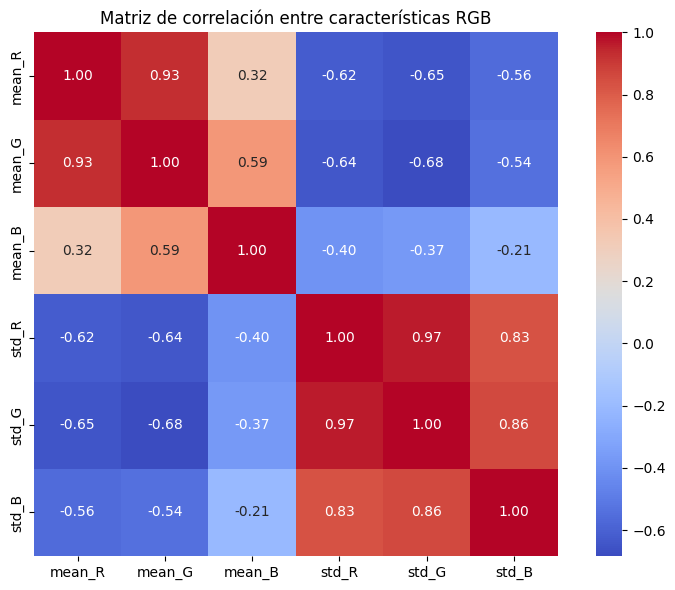

In [ ]:
corr = df_pixels[feature_cols].corr()

plt.figure(figsize=(8,6))
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True
)
plt.title("Matriz de correlación entre características RGB")
plt.tight_layout()
plt.show()

La matriz de correlación muestra relaciones moderadas a altas entre las medias de los canales RGB, lo cual es esperable dado que los canales comparten información de iluminación y tinción. Esta redundancia sugiere que una reducción de dimensionalidad o el uso de modelos capaces de aprender representaciones latentes (por ejemplo, CNN) resulta adecuado para mejorar la generalización.

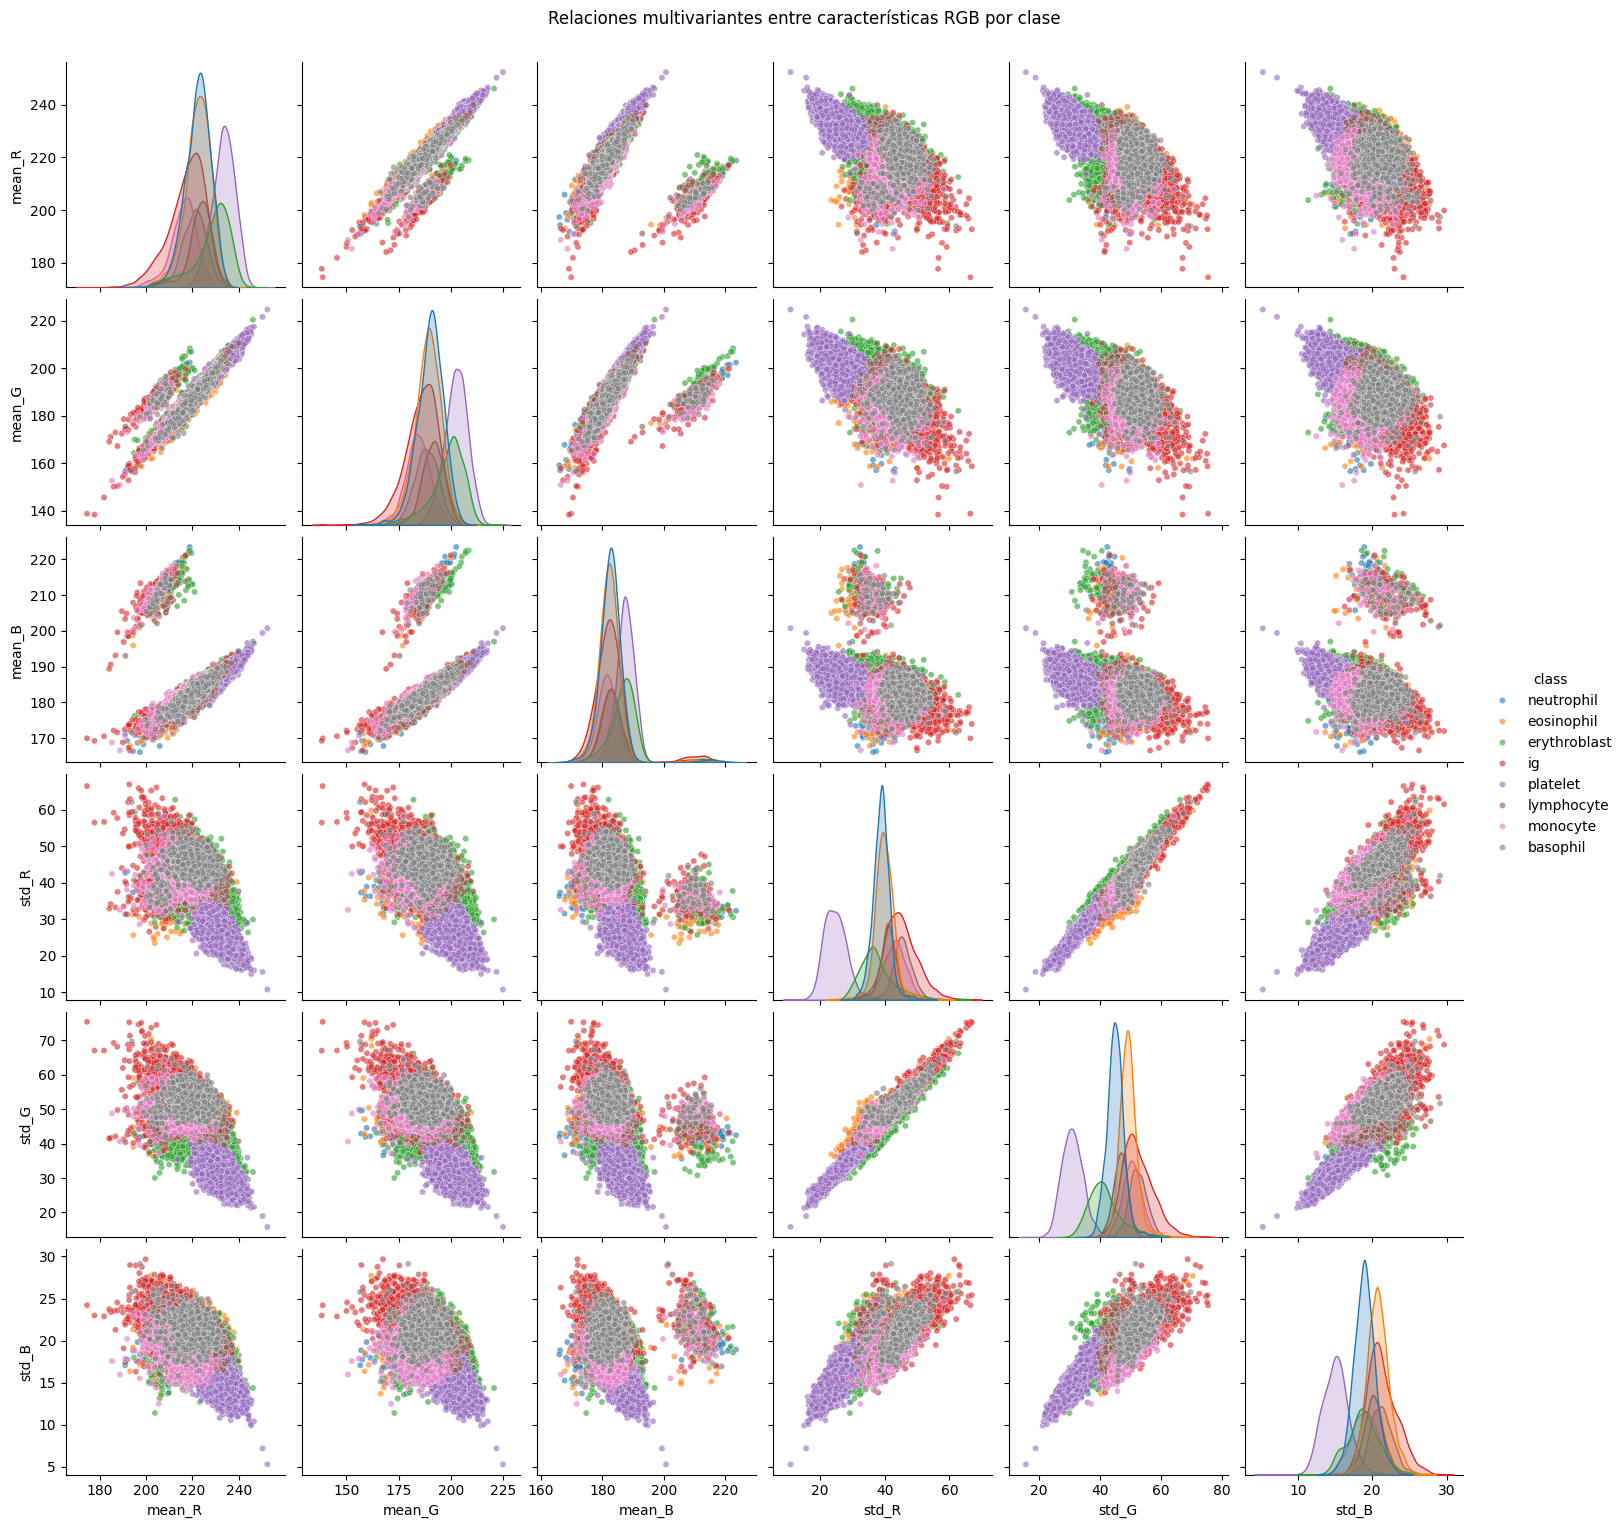

In [ ]:
sns.pairplot(
    df_pixels[feature_cols + ["class"]],
    hue="class",
    diag_kind="kde",
    plot_kws={"alpha": 0.6, "s": 20}
)
plt.suptitle("Relaciones multivariantes entre características RGB por clase", y=1.02)
plt.show()

El pairplot evidencia un solapamiento considerable entre clases cuando se utilizan únicamente estadísticas globales de intensidad, lo que indica que estas características capturan información limitada para una separación clara. Este hallazgo refuerza la necesidad de emplear modelos no lineales y representaciones de mayor nivel, como las aprendidas automáticamente por redes neuronales convolucionales, para capturar patrones espaciales y texturales más discriminativos.

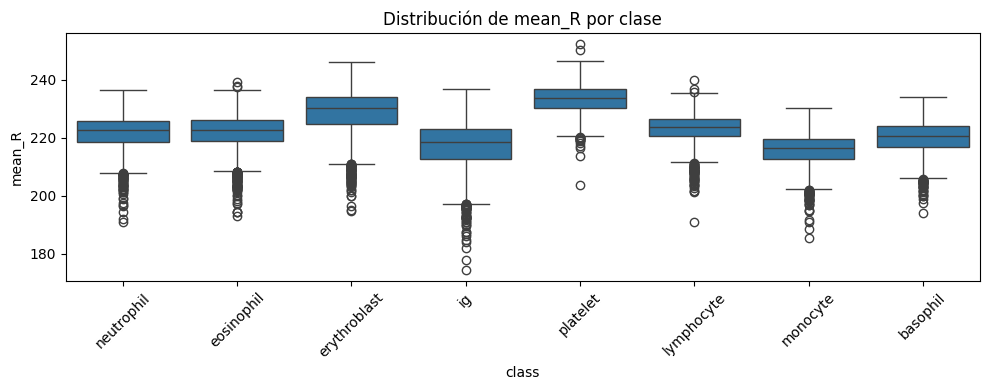

In [ ]:
plt.figure(figsize=(10,4))
sns.boxplot(
    data=df_pixels,
    x="class",
    y="mean_R"
)
plt.title("Distribución de mean_R por clase")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# **10._ ¿Se deberian normalizar las imágenes para visualizarlas mejor?**

Sí, es recomendable normalizar las imágenes, tanto para mejorar su visualización como para facilitar su posterior uso en modelos de aprendizaje automático.

Durante el análisis exploratorio se observó que las intensidades de los píxeles en los canales RGB se concentran en rangos altos (aproximadamente entre 170 y 250), lo que puede generar diferencias de contraste entre imágenes debidas a variaciones de iluminación o tinción, y no necesariamente a la morfología celular. La normalización permite reducir este efecto y mejorar la comparabilidad visual entre muestras.

Desde el punto de vista de visualización, escalar las intensidades a un rango estándar [0,1] ya que ayuda a:

Homogeneizar el contraste entre imágenes.

Evitar que diferencias globales de brillo dominen la percepción visual.

Resaltar estructuras relevantes de las células.

Adicionalmente, la normalización es una práctica estándar previa al entrenamiento de modelos, ya que estabiliza la optimización y mejora la convergencia.

# **11._ ¿Hay desequilibrio en las clases de las variable objetivo?**

Sí, el conjunto de datos presenta un desequilibrio moderado en la distribución de las clases de la variable objetivo. Aunque todas las categorías cuentan con un número considerable de imágenes, la frecuencia de las clases no es uniforme.

En particular:

Neutrophil, eosinophil e immature granulocyte (IG) son las clases con mayor número de muestras.

Basophil y lymphocyte son las clases menos representadas.

Este desbalance puede introducir un sesgo en los modelos de clasificación, favoreciendo la predicción de las clases más frecuentes si no se aplican estrategias adecuadas durante el entrenamiento.

No obstante, el desequilibrio observado no es extremo y resulta común en conjuntos de datos reales del dominio médico. Por ello, puede gestionarse mediante técnicas estándar como el uso de pesos de clase o estrategias de muestreo, sin necesidad de eliminar muestras.

# **Conclusiones**

El análisis exploratorio realizado sobre el conjunto de datos de imágenes de células sanguíneas permitió evaluar de manera integral su estructura, calidad y adecuación para el desarrollo de modelos de clasificación automática.

En primer lugar, se confirmó que el conjunto de datos no presenta valores faltantes, ya que todas las imágenes se encuentran correctamente etiquetadas y organizadas por clase. Las imágenes corresponden a células individuales previamente segmentadas, lo cual representa una ventaja al eliminar la necesidad de detección o segmentación adicional; sin embargo, también implica la limitación de no disponer de información contextual del entorno celular o en un futuro la clasificación de células por monton.

El análisis de dimensiones reveló ligeras variaciones en el tamaño de las imágenes respecto a la resolución nominal, sin identificarse valores atípicos estructurales ni archivos corruptos. Estas variaciones son consistentes con el proceso de adquisición automática y pueden ser corregidas mediante un redimensionamiento uniforme durante el preprocesamiento.

A nivel estadístico, las intensidades de los canales RGB presentan distribuciones estables, sin valores atípicos significativos. Las variaciones observadas en las intensidades y la varianza de los píxeles corresponden a diferencias naturales de intensidad y morfología entre tipos celulares, lo cual fue confirmado tanto por estadísticas descriptivas como por análisis visual mediante boxplots y el criterio del rango intercuartílico (IQR).

El análisis bivariado mostró que las características de color se distribuyen de forma diferenciada según la clase celular, aunque con solapamiento entre categorías. Esto indica que dichas características contienen información discriminativa, pero que la clasificación requiere el uso de modelos multivariados o de aprendizaje profundo para capturar patrones más complejos.

Asimismo, se identificó un desequilibrio moderado en la distribución de las clases, con algunas categorías más representadas que otras. Si bien este desbalance no es extremo, deberá considerarse durante el entrenamiento del modelo mediante técnicas como el uso de pesos de clase o aumento de datos, a fin de evitar sesgos hacia las clases mayoritarias.

Finalmente, se concluye que el conjunto de datos presenta una alta calidad, sin anomalías relevantes, y que no requiere transformaciones no lineales. No obstante, se recomienda aplicar normalización de intensidades y redimensionamiento de imágenes como parte del preprocesamiento previo al entrenamiento. En conjunto, el EDA confirma que el dataset es adecuado para el desarrollo y evaluación de modelos de clasificación automática de células sanguíneas.

# **Referencias**

A. Acevedo et al., “A dataset for microscopic peripheral blood cell images for
development of automatic recognition systems,” Mendeley Data, vol. 1, Jun. 2020. doi:
10.17632/snkd93bnjr.1.

Y. Zou, L. Wu, C. Zuo, L. Chen, B. Zhou, y H. Zhang, “White blood cell classification network using MobileNetv2 with multiscale feature extraction module and attention mechanism”, Biomedical Signal Processing and Control, vol. 99, p. 106820, ene. 2025, doi: 10.1016/j.bspc.2024.106820.

H. Li et al., “A high-performance and lightweight five-class white blood cell classification network optimized by attention mechanisms”, Neurocomputing, vol. 653, p. 131246, nov. 2025, doi: 10.1016/j.neucom.2025.131246.

K. A. Davamani, M. Jawahar, L. J. Anbarasi, V. Ravi, A. Al Mazroa, y C. R. R. Robin, “Deep transfer learning technique to detect white blood cell classification in regular clinical practice using histopathological images”, Multimed Tools Appl, vol. 84, núm. 9, pp. 5699–5723, abr. 2024, doi: 10.1007/s11042-024-19133-8.

A. Panthakkan, S. M. Anzar, W. Mansoor, y H. A. Ahmad, “A new frontier in hematology: Robust deep learning ensembles for white blood cell classification”, Biomedical Signal Processing and Control, vol. 100, p. 106995, feb. 2025, doi: 10.1016/j.bspc.2024.106995.

G. Yan et al., “Diagnosis and typing of leukemia using a single peripheral blood cell through deep learning”, Cancer Science, vol. 116, núm. 2, pp. 533–543, feb. 2025, doi: 10.1111/cas.16374.

S. Sarkar, D. C. Teja Reddy, S. Dixit, y A. Bhan, “A Deep Neural Network for Analysis of Multi-class Classification of Microscopic Blood Cell Images”, en 2025 6th International Conference on Intelligent Communication Technologies and Virtual Mobile Networks (ICICV), Tirunelveli, India: IEEE, jun. 2025, pp. 1031–1036. doi: 10.1109/ICICV64824.2025.11086010.


